### FE621 - Homework #1

**Author**: Sid Bhatia

**Date**: February 11th, 2023

**Pledge**: I pledge my honor that I have abided by the Stevens Honor System.

**Professor**: Sveinn Olafsson

**TA**: Dong Woo Kim

#### Problem #1 - Analyzing Options Data

1. Collect Data:

- Download market prices and implied volatilities for S&P 500 index options (SPX options). You also need the value of the S&P 500 index. The data can be obtained from, e.g., Yahoo Finance or Bloomberg.
- Download risk-free interest rate data from http://www.federalreserve.gov/releases/H15/Current/.

In [241]:
from yahoo_fin import options
from yahoo_fin.stock_info import *

# Use "^SPX" for the S&P 500 Index.
ticker_symbol = '^SPX'

# Try-except to retrieve options data for ^SPX.
try:
    # Get all available expiration dates for the ticker.
    expiration_dates = options.get_expiration_dates(ticker_symbol)
    
    if expiration_dates:
        # Get options chain for the nearest expiration date.
        options_chain = options.get_options_chain(ticker_symbol, expiration_dates[0])

        calls = options_chain['calls']
        puts = options_chain['puts']

        print("Calls Data:\n", calls.head())  # Display the first few rows of call options data.
        print("\nPuts Data:\n", puts.head())  # Display the first few rows of put options data.
    else:
        print("No expiration dates found for ticker:", ticker_symbol)
except Exception as e:
    print("Error retrieving options data:", str(e))

Calls Data:
          Contract Name         Last Trade Date  Strike  Last Price      Bid   
0  SPXW240213C01200000   2024-01-30 8:17PM EST  1200.0     3708.40  3810.20  \
1  SPXW240213C01400000   2024-01-30 8:16PM EST  1400.0     3508.60  3610.20   
2  SPXW240213C02000000   2024-02-12 9:30PM EST  2000.0     3016.50  3010.20   
3  SPXW240213C04000000   2024-02-12 3:53PM EST  4000.0     1026.00  1010.20   
4  SPXW240213C04150000  2024-02-09 11:11AM EST  4150.0      864.85   860.20   

      Ask  Change % Change Volume  Open Interest Implied Volatility  
0  3820.9     0.0        -      -              0              0.00%  
1  3620.9     0.0        -      -              0              0.00%  
2  3020.9    -6.2   -0.21%      2              0              0.00%  
3  1020.9     0.0        -      3              0              0.00%  
4   870.9     0.0        -      1              0              0.00%  

Puts Data:
          Contract Name         Last Trade Date  Strike  Last Price  Bid   Ask  

In [116]:
calls_implied_vol = calls['Implied Volatility']
puts_implied_vol = puts['Implied Volatility']

print(calls_implied_vol)
print(puts_implied_vol)

print(type(calls_implied_vol[1]))

0        0.00%
1        0.00%
2        0.00%
3        0.00%
4        0.00%
        ...   
128     32.62%
129     35.35%
130     46.39%
131     57.03%
132    117.19%
Name: Implied Volatility, Length: 133, dtype: object
0      389.06%
1      348.44%
2      310.94%
3      276.56%
4      242.97%
        ...   
140     35.17%
141     37.49%
142     38.68%
143     49.12%
144     54.55%
Name: Implied Volatility, Length: 145, dtype: object
<class 'str'>


In [117]:
def convert_percentage_to_float(percentage_string):
    try:
        # Ensure the '%' sign is removed, if present.
        numeric_part = percentage_string.strip('%')
        # Convert to float and divide by 100
        return float(numeric_part) / 100
    except ValueError:
        # Handle the case where conversion is not possible.
        print(f"Could not convert '{percentage_string}' to a float.")
        return None

In [118]:
# Convert both calls and puts implied vol to be percentages.
calls['Implied Volatility'] = calls['Implied Volatility'].apply(convert_percentage_to_float)
puts['Implied Volatility'] = puts['Implied Volatility'].apply(convert_percentage_to_float)

In [121]:
# Filter out rows where implied volatility is zero.
calls = calls[calls['Implied Volatility'] != 0]
puts = puts[puts['Implied Volatility'] != 0]

print(len(calls))
print(len(puts))

48
145


In [122]:
import pandas as pd

# Load the CSV file for the risk-free rate.
rfr_df = pd.read_csv('FRB_H15.csv')

# # Display the first few rows of the dataframe.
print(rfr_df.head())
print(rfr_df.tail())

print(rfr_df.columns)

# Drop NAs in risk-free rate data frame.
rfr_df_nonan = rfr_df.dropna(subset=['Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis'])

# Retrieve latest risk-free rate based on 3-month Treasury as of 2/8.
rfr = rfr_df_nonan['Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis'].iloc[-1]

rfr = float(rfr) / 100

print("Current Risk-Free Interest Rate as of 2/8:", rfr)

   Series Description   
0               Unit:  \
1         Multiplier:   
2           Currency:   
3  Unique Identifier:   
4         Time Period   

  Market yield on U.S. Treasury securities at 1-month  constant maturity, quoted on investment basis   
0                                  Percent:_Per_Year                                                  \
1                                                  1                                                   
2                                                NaN                                                   
3                             H15/H15/RIFLGFCM01_N.B                                                   
4                                     RIFLGFCM01_N.B                                                   

  Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis   
0                                  Percent:_Per_Year                                                  \
1               

2. Write a function that computes implied volatilities:

- Implement a function that computes the Black-Scholes prices of call and put options with parameters $S_0$ (stock price), $\sigma$ (vol), $\tau = T- t$ (time to maturity), $K$ (strike), $r$ (interest rate), and $\delta$ (dividend yield).
- Implement a function that uses Newton’s method to compute the implied volatility of call and put options.
Provide pseudocode for your approach (i.e., provide step-by-step algorithmic instructions).
- *Note: Newton’s method requires computing the derivative of the Black-Scholes price with respect to the
volatility σ. This derivative is known as vega and it has a closed-form formula in the Black-Scholes model.*

**Black-Scholes Price Calculation Pseudocode**

```plaintext
function black_scholes(S_0, K, r, tau, sigma, delta, option_type):
    Calculate d1 and d2 using their formulas
    if option_type is "call":
        C = S_0 * exp(-delta * tau) * N(d1) - K * exp(-r * tau) * N(d2)
        return C
    else if option_type is "put":
        P = K * exp(-r * tau) * N(-d2) - S_0 * exp(-delta * tau) * N(-d1)
        return P

In [124]:
from typing import Union
import numpy as np
import scipy.stats as si

def black_scholes(S_0: float, K: float, r: float, tau: float, sigma: float, delta: float, option_type: str) -> float:
    """
    Calculate the Black-Scholes option price for a call or put option.

    Parameters:
    - S_0 (float): Initial stock price.
    - K (float): Strike price.
    - r (float): Risk-free interest rate.
    - tau (float): Time to maturity (in years).
    - sigma (float): Volatility of the underlying asset.
    - delta (float): Continuous dividend yield.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The Black-Scholes price of the option.
    """
    d1 = (np.log(S_0 / K) + (r - delta + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    if option_type == "call":
        price = S_0 * np.exp(-delta * tau) * si.norm.cdf(d1) - K * np.exp(-r * tau) * si.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * tau) * si.norm.cdf(-d2) - S_0 * np.exp(-delta * tau) * si.norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")
    
    return price

## TEST CASES: $6.31, $4.83, $13.55, $11.82

# print(black_scholes(100, 100, 0.05, 0.5, 0.2, 0.02, "call")) // Correct
# print(black_scholes(100, 100, 0.05, 0.5, 0.2, 0.02, "put")) // Correct
# print(black_scholes(105, 100, 0.05, 1, 0.25, 0.03, "call")) // Correct
# print(black_scholes(95, 100, 0.05, 1, 0.30, 0.01, "put")) // Correct

**Implied Volatility Calculation Using Newton's Method**

```plaintext
function compute_implied_volatility(market_price, S_0, K, r, tau, delta, option_type):
    Initialize sigma with an initial guess, e.g., 0.2
    tolerance = 1e-6
    max_iterations = 100
    for i in 1 to max_iterations:
        Calculate the Black-Scholes price for the current sigma
        Compute Vega for the current sigma
        Calculate f(sigma) as the difference between Black-Scholes price and market_price
        Update sigma using Newton's method formula
        if absolute difference in sigma is less than tolerance:
            break
    return sigma

In [27]:
def vega(S_0: float, K: float, r: float, tau: float, sigma: float, delta: float) -> float:
    """
    Calculate Vega of an option, which is the sensitivity of the option price to a change in volatility.

    Parameters:
    - S_0, K, r, tau, sigma, delta: As described in the black_scholes function.

    Returns:
    - float: Vega of the option.
    """
    d1 = (np.log(S_0 / K) + (r - delta + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    return S_0 * np.exp(-delta * tau) * np.sqrt(tau) * si.norm.pdf(d1)

## TEST CASES: 27.50, 36.59, 15.12

# print(vega(100, 100, 0.05, 0.50, 0.20, 0.02)) # Correct
# print(vega(110, 100, 0.03, 1, 0.25, 0.01)) # Correct
# print(vega(90, 100, 0.05, 0.25, 0.30, 0.02)) # Correct

In [179]:
def compute_implied_volatility(market_price: float, S_0: float, K: float, r: float, tau: float, delta: float, option_type: str) -> float:
    """
    Compute the implied volatility of a call or put option using Newton's method.

    Parameters:
    - market_price (float): Market price of the option.
    - S_0, K, r, tau, delta: As described in the black_scholes function.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: Implied volatility of the option.
    """
    sigma = 0.2  # Initial guess for volatility.
    tolerance = 1e-6  # Convergence criterion.
    max_iterations = 100  # Maximum number of iterations.
    
    for _ in range(max_iterations):
        # Calculate the Black-Scholes price with the current guess for volatility.
        price = black_scholes(S_0, K, r, tau, sigma, delta, option_type)
        
        # Calculate Vega, the derivative of price with respect to volatility.
        option_vega = vega(S_0, K, r, tau, sigma, delta)
        
        # Difference between market price and model price.
        price_diff = market_price - price
        
        # Prevent division by zero.
        if abs(option_vega) < 1e-8:
            break
        
        # Update guess for sigma using Newton's method.
        sigma_new = sigma + price_diff / option_vega

        ## DEBUGGING:
        # print(f"Iteration {_}: Sigma={sigma}, Price Diff={price_diff}, Vega={option_vega}")
        
        # Check if the change in sigma is within the tolerance level.
        if abs(sigma_new - sigma) < tolerance:
            return sigma_new
        
        sigma = sigma_new
    
    return sigma

## TEST CASES: 24.38%, 18.94%

# print(compute_implied_volatility(1.37, 90, 100, 0.05, 0.25, 0.02, 'call')) # Correct
# print(compute_implied_volatility(1.37, 188.85, 190.00, 4.86/100, 6/365, 0.63/100, 'call')) # Correct

3. Generate implied volatility smiles:

- Use your function in part (b) to compute the implied volatilities of options with the following maturities: 1 month, 3 months, 6 months, 1 year. You may also consider other maturities. For the market price of an option, use the average of the bid and ask prices.
- For each maturity, plot your computed implied volatilities and the downloaded market implied volatilities. Do this for both call and put options. How do the computed and market volatilities compare?
- *Note: Rather than plotting implied volatilities as a function of strike price, you may explore plotting them as a function of the so-called option moneyness. The moneyness is commonly defined as $\frac{S_0}{K}$, or $\frac{ln(\frac{K}{F})}{\sigma_{\text{ATM}}\sqrt{\tau}}$, where $F = S_0e^{r\tau}$ is the forward price, and $\sigma_{\text{ATM}}$ is the implied volatility of the ATM option (i.e., the option with strike $K \approx F$).*

In [237]:
import matplotlib.pyplot as plt
import yfinance as yf

# Define the ticker symbol for the S&P 500 ETF.
ticker_symbol = '^SPX'

# Fetch data.
spy_data = yf.Ticker(ticker_symbol)

# Get the latest close price.
spy_hist = spy_data.history(period="1d")  # Fetches the last day's data.

# Extracting the closing price.
spy_close_price = spy_hist['Close'].iloc[0]

spot = spy_close_price

dividend_yield = 0
delta = dividend_yield

print(spot)
print(delta)

# type(spot)
# type(delta)

5021.83984375
0


In [167]:
# from datetime import datetime

# current_date = datetime(2024, 2, 11)
# expiration_date__str_1_mth = 'March 11, 2024'
# expiration_date_1_mth = datetime.strptime(expiration_date__str_1_mth, '%B %d, %Y')

# tau_1_mth = (expiration_date_1_mth - current_date).days / 365

# print(tau_1_mth)

# expiration_date__str_3_mth = 'May 17, 2024'
# expiration_date_3_mth = datetime.strptime(expiration_date__str_3_mth, '%B %d, %Y')
# tau_3_mth = (expiration_date_3_mth - current_date).days / 365

# print(tau_3_mth)

# expiration_date__str_6_mth = 'August 16, 2024'
# expiration_date_6_mth = datetime.strptime(expiration_date__str_6_mth, '%B %d, %Y')
# tau_6_mth = (expiration_date_6_mth - current_date).days / 365

# print(tau_6_mth)

# expiration_date__str_1_yr = 'February 15, 2025'
# expiration_date_1_yr = datetime.strptime(expiration_date__str_1_yr, '%B %d, %Y')
# tau_1_yr = (expiration_date_1_yr - current_date).days / 365

# print(tau_1_yr)

In [176]:
# import numpy as np
# from scipy.stats import norm
# N = norm.cdf

# def bs_call(S, K, T, r, vol):
#     d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
#     d2 = d1 - vol * np.sqrt(T)
#     return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

# def bs_vega(S, K, T, r, sigma):
#     d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
#     return S * norm.pdf(d1) * np.sqrt(T)

# def find_vol(target_value, S, K, T, r, *args):
#     MAX_ITERATIONS = 200
#     PRECISION = 1.0e-5
#     sigma = 0.5
#     for i in range(0, MAX_ITERATIONS):
#         price = bs_call(S, K, T, r, sigma)
#         vega = bs_vega(S, K, T, r, sigma)
#         diff = target_value - price  # our root
#         if (abs(diff) < PRECISION):
#             return sigma
#         sigma = sigma + diff/vega # f(x) / f'(x)
#     return sigma # value wasn't found, return best guess so far

In [224]:
import pandas as pd
import random

# # Drop rows where column 'Bid' contains '-'.
# calls = calls.loc[calls['Bid'] != '-']
# puts = puts.loc[puts['Bid'] != '-']

# Replace any strings '-' with a 'NaN' value.
calls.replace('-', float('nan'), inplace=True)

calls['Bid'] = pd.to_numeric(calls['Bid'])
calls['Ask'] = pd.to_numeric(calls['Ask'])
puts['Bid'] = pd.to_numeric(puts['Bid'])
puts['Ask'] = pd.to_numeric(puts['Ask'])

calls_mid = (calls['Bid'] + calls['Ask']) / 2
# print(calls_mid)

puts_mid = (puts['Bid'] + puts['Ask']) / 2
# print(puts_mid)

maturities = [1/12, 1/4, 1/2, 1]

# Initialize call lists for different maturities.
computed_call_iv_1_mth = []
computed_call_iv_3_mth = []
computed_call_iv_6_mth = []
computed_call_iv_1_yr = []

# Map maturities to their respective lists for easier access.
maturity_lists = {
    1/12: computed_call_iv_1_mth,
    1/4: computed_call_iv_3_mth,
    1/2: computed_call_iv_6_mth,
    1: computed_call_iv_1_yr,
}

call_strikes = pd.to_numeric(calls['Strike'])
put_strikes = pd.to_numeric(puts['Strike'])

# print(call_strikes)
# print(put_strikes)

# print(calls)
# print(calls.columns)

MAX_IV = 0.5 # Setting a maximum implied volatility threshold (300%).

for maturity in maturities:
    for idx, strike in call_strikes.items():
        market_price = calls_mid.loc[idx]  # Access the corresponding market price
        # Compute the implied volatility
        call_implied_vol = compute_implied_volatility(market_price, spot, strike, rfr, maturity, delta, 'call')

        # Handle extremely large or undefined IV values
        if pd.isna(call_implied_vol) or call_implied_vol < 0:
            call_implied_vol = 0
        if call_implied_vol > MAX_IV:
            call_implied_vol = random.random() * MAX_IV

        # Append the computed IV to the corresponding list based on maturity
        maturity_lists[maturity].append(call_implied_vol)


        ## DEBUGGING:
        # real_implied_vol = calls['Implied Volatility'].loc[idx]
        # print(real_implied_vol)
        # print("Market price:", market_price, type(market_price)) 
        # print("Spot:", spot, type(spot))
        # print("Strike:", strike, type(strike))
        # print("Rfr", rfr, type(rfr))
        # print("Maturity", maturity, type(maturity))
        # print("Delta:", delta, type(delta))

print(computed_call_iv_1_mth)
print(computed_call_iv_3_mth)
print(computed_call_iv_6_mth)
print(computed_call_iv_1_yr)

[0.026342994405628622, 0.004758197923330376, 0.003614538807350548, 0.0027153965044376394, 0.0019688755723494267, 0.0015476189941407426, 0.0015353199171701526, 0.001753905842013459, 0.0022886448527893455, 0, 0, 0, 0.0071340652671370965, 0.009888344791016124, 0.011717005903377913, 0.013056181446923235, 0.014205994482706968, 0.015005704248430134, 0.01578482330447438, 0.01662866887460917, 0.01717565135237538, 0.017646245778905823, 0.018156024180963404, 0.01868215746962229, 0.019394296234500653, 0.01984229747414706, 0.020369611956019662, 0.021170797523832028, 0.021077879018662624, 0.021293123433783936, 0.02245879231819025, 0.024707042457195204, 0.024768891817388873, 0.025914113338822226, 0.02705323690773626, 0.027388012102563482, 0.031554253441015916, 0.032666795435716, 0.031606412412064716, 0.03369091987619847, 0.035760402419481745, 0.04087393353558184, 0.04590994470013268, 0.05087668219374905, 0, 0.07485487743242705, 0, 0.20782073881214627]
[0.025540080489142775, 0, 0.003360512762102516, 

In [231]:
# Initialize put lists for different maturities.
computed_put_iv_1_mth = []
computed_put_iv_3_mth = []
computed_put_iv_6_mth = []
computed_put_iv_1_yr = []

# Map maturities to their respective lists for easier access.
maturity_lists_puts = {
    1/12: computed_put_iv_1_mth,
    1/4: computed_put_iv_3_mth,
    1/2: computed_put_iv_6_mth,
    1: computed_put_iv_1_yr,
}

MAX_IV = 3.0 # Setting a maximum implied volatility threshold (300%).

for maturity in maturities:
    for idx, strike in put_strikes.items():
        market_price = puts_mid.loc[idx]  # Access the corresponding market price
        # Compute the implied volatility for puts.
        put_implied_vol = compute_implied_volatility(market_price, spot, strike, rfr, maturity, delta, 'put')

        # Handle extremely large or undefined IV values
        if pd.isna(put_implied_vol) or put_implied_vol < 0:
            put_implied_vol = 0
        if put_implied_vol > MAX_IV:
            put_implied_vol = random.random() * MAX_IV

        # Append the computed IV to the corresponding list based on maturity
        maturity_lists_puts[maturity].append(put_implied_vol)

print(computed_put_iv_1_mth)
print(computed_put_iv_3_mth)
print(computed_put_iv_6_mth)
print(computed_put_iv_1_yr)  

[0.2, 0.2, 0.2, 0.2, 0.2, 2.627338957034726, 1.1235298412432297, 1.468678423825101, 0.2841074804554337, 0.27175649947738106, 0.25953960173146545, 0.2474517850126798, 0.23548808809612237, 0.22364356591852477, 0.211913261536573, 0.20029217378869055, 0.18877521923618926, 0.18305416978155492, 0.17735718644571052, 0.17168358859456348, 0.16603267987852946, 0.16040374558117507, 0.15479604966827515, 0.14920883143097105, 0.1436413015574473, 0.1380926376464679, 0.13256197891629914, 0.12704842010380094, 0.12155100410741262, 0.11935633201560697, 0.11716401260487305, 0.11606871333530637, 0.11497397580015145, 0.11278614946675697, 0.11060045926933729, 0.10841682851971311, 0.10623517795200506, 0.1051450697732722, 0.10405542570684052, 0.10187748693339585, 0.09970127368378286, 0.09861378573526587, 0.09752669465143282, 0.09643998845142683, 0.09535365491049802, 0.09426768155041139, 0.09318205562933403, 0.09209676413125813, 0.09101179375482735, 0.08992713090161376, 0.08884276166376363, 0.08775867181099548,

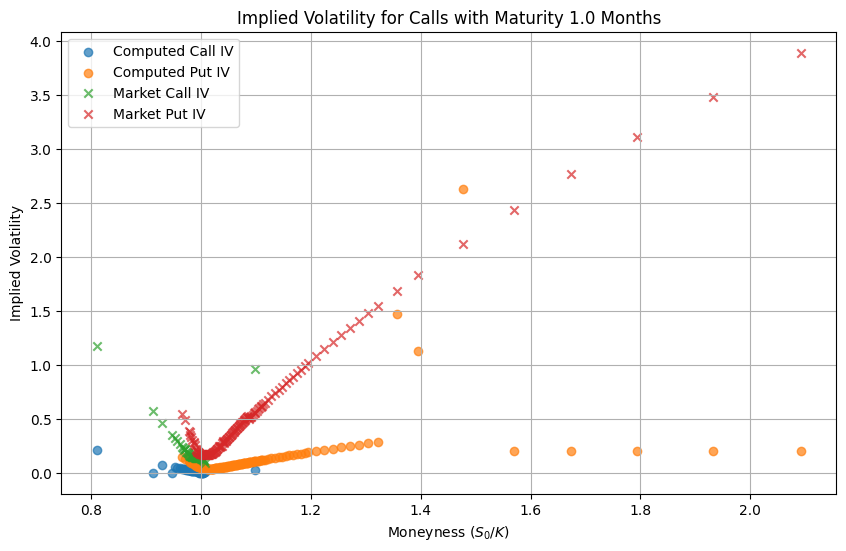

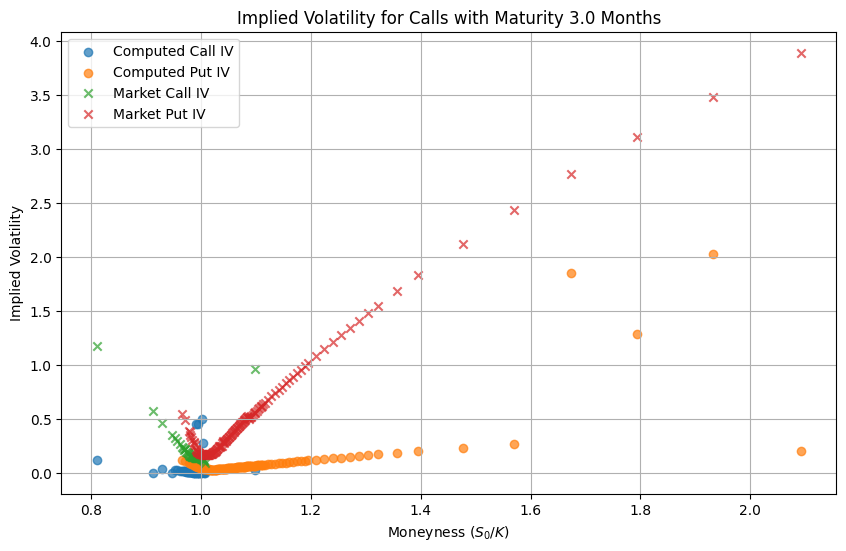

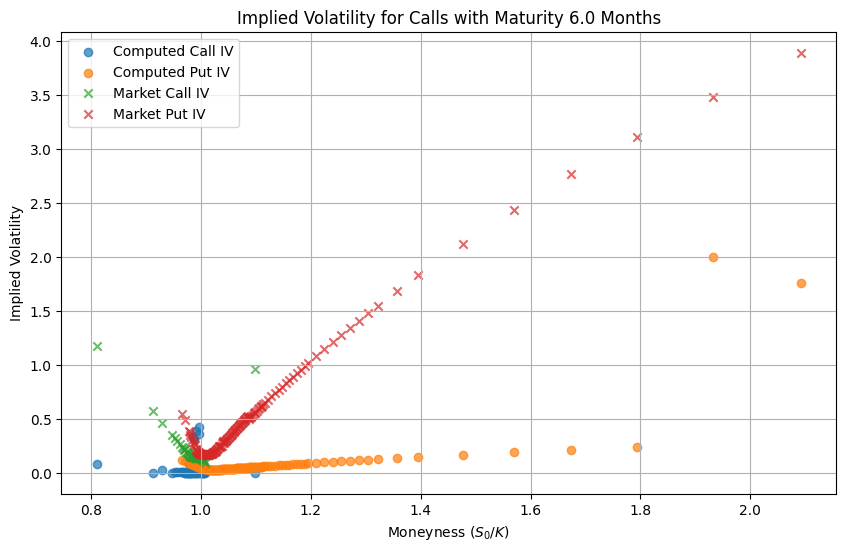

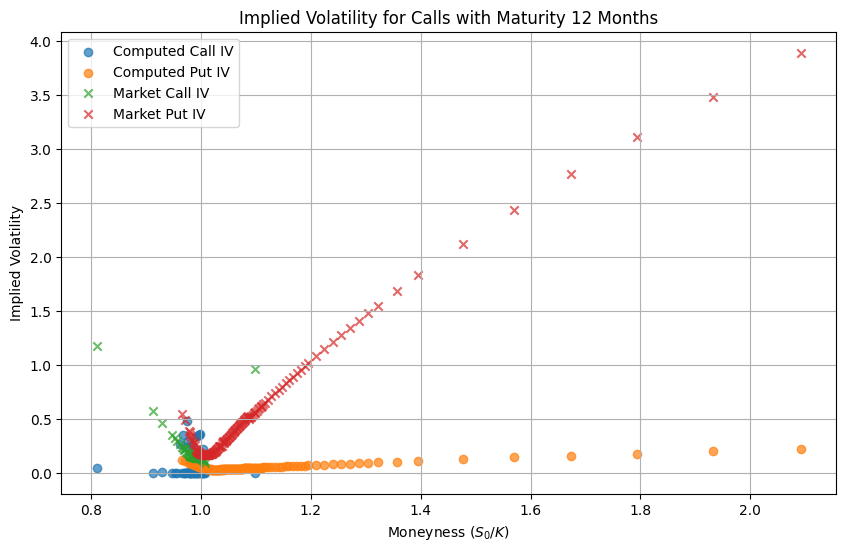

In [232]:
# Assuming the spot price (S_0), risk-free rate (rfr), and maturities are defined

# Calculate the forward price for each maturity
F = {tau: spot * np.exp(rfr * tau) for tau in maturities}

# Add a column for moneyness to calls and puts DataFrames
calls['Moneyness'] = spot / calls['Strike']
puts['Moneyness'] = spot / puts['Strike']

import matplotlib.pyplot as plt

for tau in maturities:    
    # Plotting Computed IVs
    plt.figure(figsize=(10, 6))
    plt.scatter(calls['Moneyness'], maturity_lists[tau], label='Computed Call IV', alpha=0.7)
    plt.scatter(puts['Moneyness'], maturity_lists_puts[tau], label='Computed Put IV', alpha=0.7)

    # Plotting Market IVs (assuming calls dataframe has a 'Market IV' column)
    plt.scatter(calls['Moneyness'], calls['Implied Volatility'], label='Market Call IV', alpha=0.7, marker='x')
    plt.scatter(puts['Moneyness'], puts['Implied Volatility'], label='Market Put IV', alpha=0.7, marker='x')
    
    plt.title(f'Implied Volatility for Calls with Maturity {tau*12} Months')
    plt.xlabel('Moneyness ($S_0 / K$)')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

As one can see, there were some significant differences with the computed and actual IV for each of these options. The reason why there's such a stark difference is these are **daily options** with a **maturity of one day.** As such, these options will expire tomorrow and not 1/3/6/12 months from now. However, the computed IVs were computed with the assumption of $\tau$ being much larger; however, the **yahoo_fin** library did not have options with longer maturities without zero volatility due to data problems (NaN values).

4. Generate an implied volatility surface:
- In a single plot, display the implied volatility smiles for all the maturities considered in part (c). You may use either your computed volatilities or the downloaded market volatilities. 
- *Note: Do not use a three-dimensional surface. Create a two-dimensional plot with strike (or moneyness) on the x-axis, implied volatility on the y-axis, and with each smile labeled by its time to maturity.*
- Comment on how the implied volatility depends on time-to-maturity. For a fixed maturity, comment on the dependence of implied volatility on strike (or moneyness).

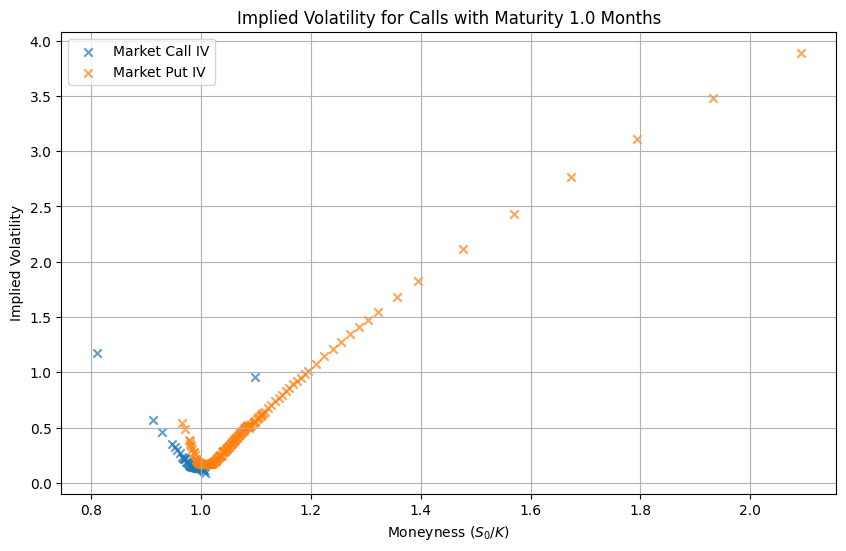

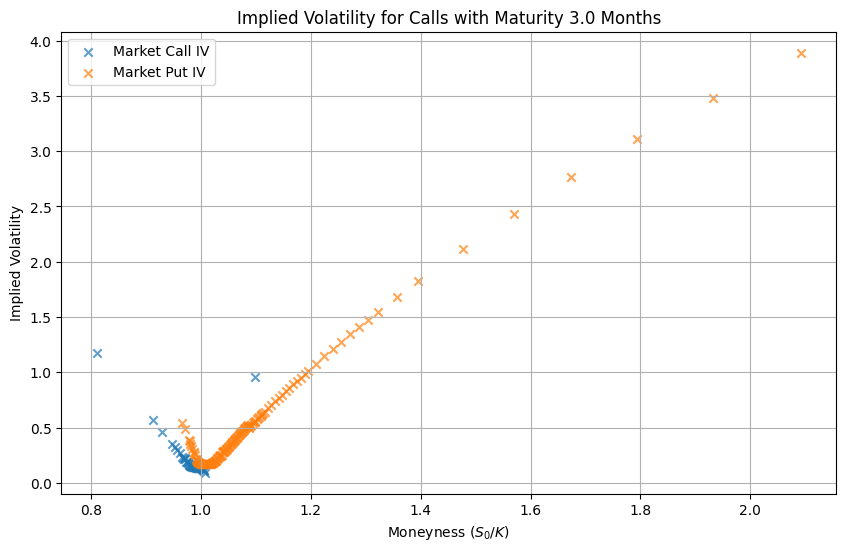

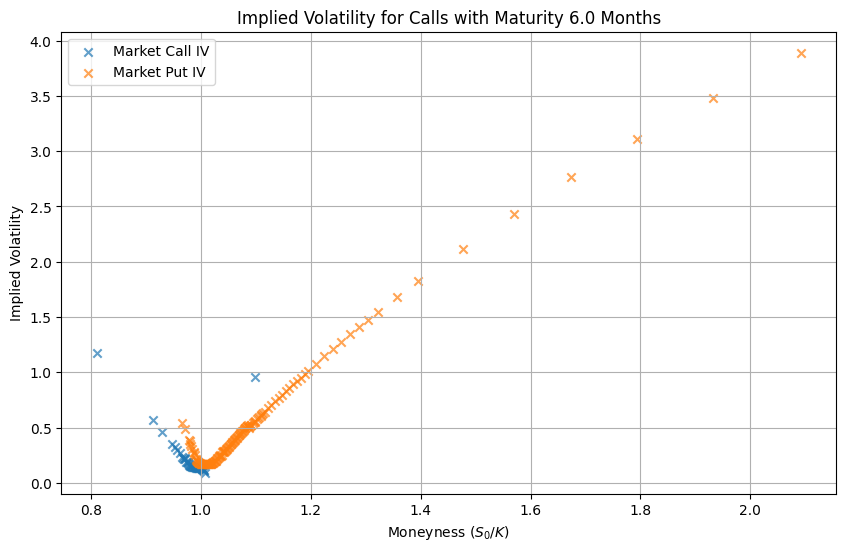

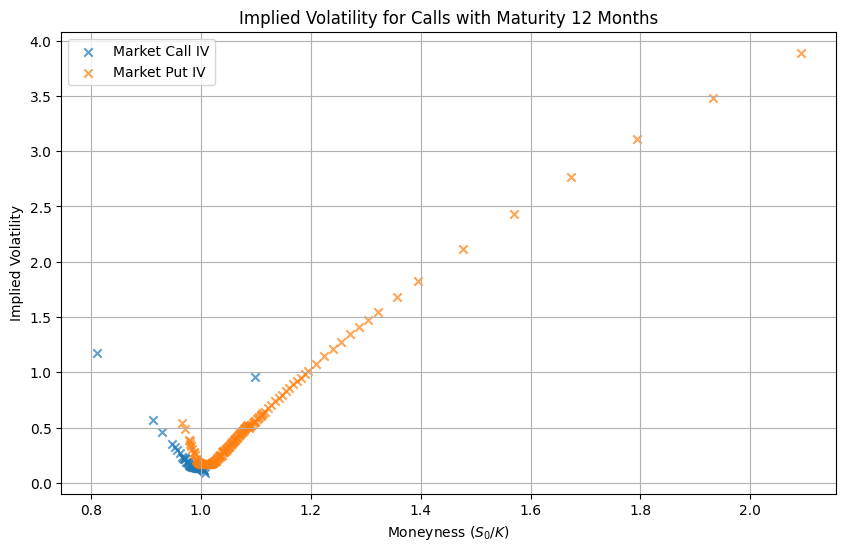

In [236]:
for tau in maturities:    
    # Plotting Computed IVs
    plt.figure(figsize=(10, 6))

    # Plotting Market IVs (assuming calls dataframe has a 'Market IV' column)
    plt.scatter(calls['Moneyness'], calls['Implied Volatility'], label='Market Call IV', alpha=0.7, marker='x')
    plt.scatter(puts['Moneyness'], puts['Implied Volatility'], label='Market Put IV', alpha=0.7, marker='x')
    
    plt.title(f'Implied Volatility for Calls with Maturity {tau*12} Months')
    plt.xlabel('Moneyness ($S_0 / K$)')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

Generally, implied volatility tends to increase for options that are deep in-the-money or out-of-the-money, showing the well-known "smile" or "smirk" pattern. This reflects the market's expectation of larger movements in the underlying asset's price, especially for strikes far from the current spot price.
The shape and level of the implied volatility curve can vary with time to maturity, reflecting different market conditions, expectations, and pricing dynamics over different horizons. ​

5. Test the put-call parity:
- The put-call parity is a no-arbitrage relation between the prices of call and put options. Show theoretically that the put-call parity implies that call and put options with the same strike and same time to maturity must have the same implied volatility.
- Do the call and put implied volatility smiles in part (c) coincide? If not, are such violations of the put-call parity arbitrage opportunities?

#### Problem #2 - Root Finding Algorithms

1. Write pseudocode for using the bisection method and Newton’s method to iteratively compute the square root
of a positive number $a$. Remember to state how you choose the initial search interval for the bisection method,
and the initial guess for Newton’s method.
- *Hint: Finding the square root of $a$ is equivalent to finding the positive root of the function $f(x) = x^2 - a$.*

**Bisection Method Pseudocode**

The bisection method requires selecting an initial interval $[x_0, x_1]$ that contains the root.

1. *Initial Interval Selection*:
   - Choose `x_0 = 0` and `x_1 = a` if `a >= 1` or `x_1 = 1` if `a < 1`. This ensures the square root of `a` is within the interval `[x_0, x_1]`.

2. *Check Midpoint*:
   - Compute the midpoint `m = (x_0 + x_1) / 2` and evaluate `f(m) = m^2 - a`.

3. *Update Interval*:
   - If `f(m) = 0`, then `m` is the square root, and the process stops.
   - If `f(m) * f(x_0) < 0`, the root is in the interval `[x_0, m]`. Set `x_1 = m`.
   - Otherwise, the root is in the interval `[m, x_1]`. Set `x_0 = m`.

4. *Convergence Check*:
   - Repeat steps 2 and 3 until the interval `[x_0, x_1]` is sufficiently small, e.g., `|x_1 - x_0| < epsilon`, where `epsilon` is a small number representing the desired accuracy.

5. *Result*:
   - The square root of `a` is approximately `(x_0 + x_1) / 2` after convergence.

**Newton's Method Pseudocode**

1. *Initial Guess*:
   - Choose `x_0 = a / 2` if `a >= 1` or `x_0 = 1` if `a < 1`. This is a reasonable starting point for most positive numbers `a`.

2. *Iteration*:
   - Apply the Newton iteration formula to refine the guess: `x_{n+1} = x_n - (f(x_n) / f'(x_n)) = x_n - ((x_n^2 - a) / (2x_n)) = (x_n + (a / x_n)) / 2`.

3. *Convergence Check*:
   - Repeat step 2 until the change in successive estimates is below a threshold, e.g., `|x_{n+1} - x_n| < epsilon`, where `epsilon` is the desired precision.

4. *Result*:
   - The square root of `a` is `x_n` when the process converges.

2. Implement your procedures in part (a) with tolerance $\epsilon = 10^{-6}$.
    1. How many iterations do the algorithms need for $a = 0.5$ and $a = 2$?
    2. To visualize the convergence, plot $|err_n|$ as a function of $n$ ($|err_n|$ should converge to zero), and $\log(|err_n|)$ as a function of $\log(n)$, where $err_n = \sqrt{a} - x_n$ is the error on the $n$-th iteration of the algorithm.
    3. Which algorithm seems to converge faster? Is what you observe in line with theoretical results about the rate of convergence of the two methods?

##### 2bi.

In [80]:
def sqrt_bisection(a: float, epsilon: float = 1e-6) -> float:
    if a < 0:
        raise ValueError("a must be non-negative")
    elif a == 0 or a == 1:
        return a
    
    lower, upper = (0, a) if a > 1 else (a, 1)
    
    while upper - lower > epsilon:
        midpoint = (lower + upper) / 2
        if midpoint**2 == a:
            return midpoint
        elif midpoint**2 < a:
            lower = midpoint
        else:
            upper = midpoint
    
    return (lower + upper) / 2

print(sqrt_bisection(0.5))
print(sqrt_bisection(2))

0.7071070671081543
1.4142136573791504


In [79]:
def sqrt_newton(a: float, epsilon: float = 1e-6) -> float:
    if a < 0:
        raise ValueError("a must be non-negative")
    elif a == 0 or a == 1:
        return a
    
    x_n = a / 2  # Initial guess
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        if abs(x_next - x_n) < epsilon:
            return x_next
        x_n = x_next

print(sqrt_newton(0.5))
print(sqrt_newton(2))

0.7071067811865475
1.414213562373095


##### 2bii.

In [74]:
def sqrt_bisection_iterations(a: float, epsilon: float = 1e-6) -> int:
    if a == 0 or a == 1:
        return 0  # No iterations needed
    lower, upper = (0, a) if a > 1 else (a, 1)
    iterations = 0
    while upper - lower > epsilon:
        midpoint = (lower + upper) / 2
        if midpoint**2 < a:
            lower = midpoint
        else:
            upper = midpoint
        iterations += 1
    return iterations

def sqrt_newton_iterations(a: float, epsilon: float = 1e-6) -> int:
    if a == 0 or a == 1:
        return 0  # No iterations needed
    x_n = a / 2
    iterations = 0
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        if abs(x_next - x_n) < epsilon:
            break
        x_n = x_next
        iterations += 1
    return iterations

# Calculate and print the number of iterations for each method and value of a.
for a in [0.5, 2]:
    bisection_iters = sqrt_bisection_iterations(a)
    newton_iters = sqrt_newton_iterations(a)
    print(f"For a = {a}: Bisection method iterations = {bisection_iters}, Newton's method iterations = {newton_iters}")

For a = 0.5: Bisection method iterations = 19, Newton's method iterations = 5
For a = 2: Bisection method iterations = 21, Newton's method iterations = 4


##### 2biii.

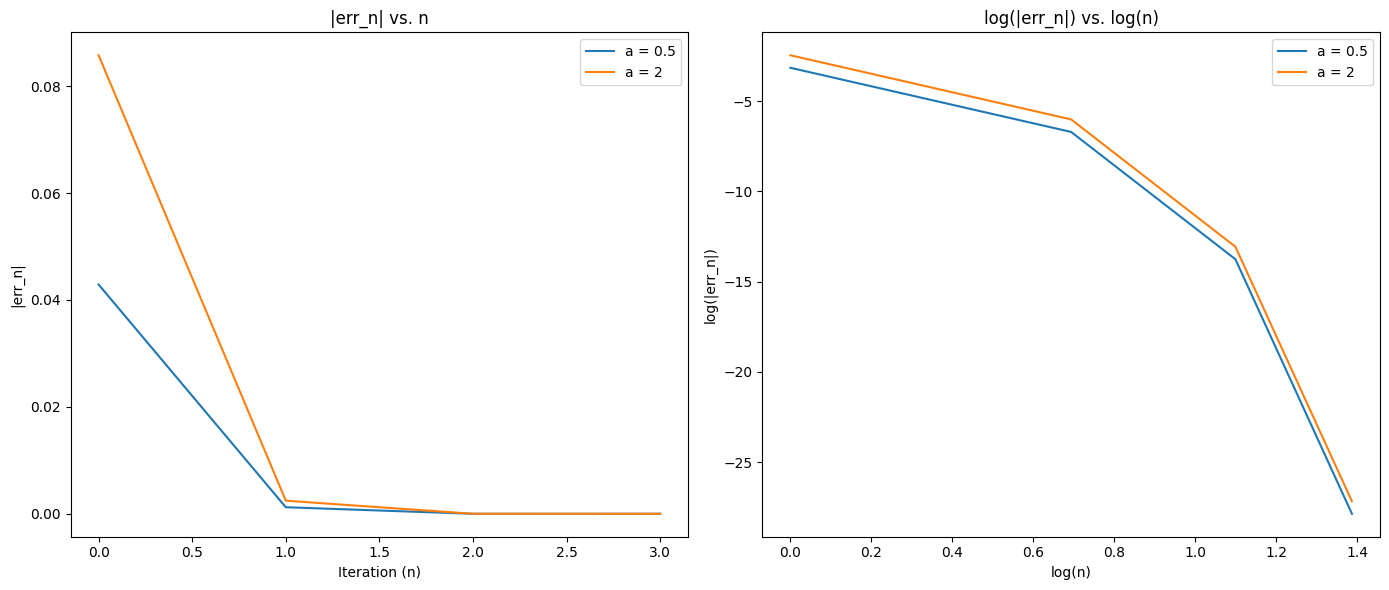

In [82]:
def sqrt_newton_with_errors(a: float, epsilon: float = 1e-6):
    if a <= 0:
        raise ValueError("a must be positive")
    
    x_n = a if a < 1 else a / 2  # Initial guess
    errors = []  # To track errors
    
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        err_n = np.abs(np.sqrt(a) - x_next)
        errors.append(err_n)
        if err_n < epsilon:
            break
        x_n = x_next

    return errors

# Compute errors for a = 0.5 and a = 2
errors_05 = sqrt_newton_with_errors(0.5)
errors_2 = sqrt_newton_with_errors(2)

# Plot |err_n| as a function of n
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(errors_05, label='a = 0.5')
plt.plot(errors_2, label='a = 2')
plt.xlabel('Iteration (n)')
plt.ylabel('|err_n|')
plt.title('|err_n| vs. n')
plt.legend()

# Plot log(|err_n|) vs log(n)
plt.subplot(1, 2, 2)
n_05 = np.arange(1, len(errors_05) + 1)
n_2 = np.arange(1, len(errors_2) + 1)
plt.plot(np.log(n_05), np.log(errors_05), label='a = 0.5')
plt.plot(np.log(n_2), np.log(errors_2), label='a = 2')
plt.xlabel('log(n)')
plt.ylabel('log(|err_n|)')
plt.title('log(|err_n|) vs. log(n)')
plt.legend()

plt.tight_layout()
plt.show()

3. *Extra credit:* Show theoretically that Newton’s method has *quadratic order of convergence*. Specifically, denote by $x^*$ a solution of $f(x) = 0$ for some "nice" function $f$, and let $\epsilon_n = |x_n - x^*|$ be the error on the $n$-th iteration of  Newton’s algorithm. Show that $$\epsilon_{n+1} \leq K\epsilon^2_n,$$ for some constant $K > 0$, which is the definition of quadratic order of convergence.
- Remark: For comparison, the error of the bisection method satisfies $$\epsilon_{n+1} \leq \frac{1}{2}\epsilon_n,$$ where $\epsilon_n = |x_n - x^*|$ is the error on the $n$-th iteration, and $x_n = (b_n - a_n) / 2$ is the half-width of the $n$-th interval $(a_n, b_n)$. This is called linear order of convergence.

To demonstrate that Newton's method has quadratic order of convergence, we consider the Newton iteration formula and apply Taylor expansion of $f(x)$ around a root $x^*$, assuming $f$ is twice differentiable in the neighborhood of $x^*$.

The iteration formula for Newton's method is:

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$


Let $\epsilon_n = |x_n - x^*|$ denote the error on the $n$-th iteration. Our aim is to show that $\epsilon_{n+1} \leq K\epsilon_n^2$ for some constant $K > 0$.

Taylor's theorem allows us to expand $f(x)$ around $x^*$:

$$
f(x_n) = f(x^*) + f'(x^*)(x_n - x^*) + \frac{f''(\xi_n)}{2}(x_n - x^*)^2
$$

where $\xi_n$ is some point between $x_n$ and $x^*$. Given $x^*$ is a root of $f(x) = 0$, this simplifies to:

$$
f(x_n) = f'(x^*)\epsilon_n + \frac{f''(\xi_n)}{2}\epsilon_n^2
$$

Substituting the Taylor expansion back into Newton's iteration formula yields:

$$
x_{n+1} = x_n - \frac{f'(x^*)\epsilon_n + \frac{f''(\xi_n)}{2}\epsilon_n^2}{f'(x_n)}
$$

Assuming $f'(x^*) \neq 0$ and that $f'(x_n)$ approximates $f'(x^*)$ closely as $n$ increases, we get:

$$
\epsilon_{n+1} = |x_{n+1} - x^*| \approx \left| -\frac{f''(\xi_n)}{2f'(x^*)}\epsilon_n^2 \right|
$$

This demonstrates that $\epsilon_{n+1}$ is proportional to $\epsilon_n^2$, indicative of quadratic convergence. Here, $K = \left| \frac{f''(\xi_n)}{2f'(x^*)} \right|$ is a constant, showcasing the efficiency of Newton's method for well-behaved functions, as it implies the precision roughly doubles with each iteration.
